### Imports

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
from IPython.display import display, clear_output
import helpfunction as helper
import matplotlib.patches as patches

pd.set_option('display.max_columns', 500)

In [3]:
%autoreload

### Constants

In [4]:
gr = (1 + 5 ** 0.5) / 2
outdir= './output/NueCC/'
inputdir = './input/'  

In [5]:
dict_names = ['nue','nu','on','off']

fidvol_vtx = [10,10,10,10,10,50] 
fidvol_end = [5,5,5,5,5,5]

kin_min = 0.02

In [6]:
triggers_off = 10119897.0
triggers_on = 10188735
pot_on = 4.35e19
pot_nue = 4.574e+22
pot_nu = 1.91e+20

title_str = "MicroBooNE {0:.2g} POT, INTERNAL".format(pot_on)
sig_str = r"$\nu_e \: CC$"
scale_off = triggers_on / triggers_off
scale_nu = pot_on / pot_nu
scale_nue = pot_on / pot_nue
scale_on = 1

#['nue','nu','on','off'] 
scales = [scale_nue, scale_nu, scale_on, scale_off]
print(scales)

[0.0009510275470048098, 0.22774869109947643, 1, 1.00680224314536]


### Definitions

In [7]:
def eventHash(df):
    return df.apply(lambda x: hash(tuple(x)), axis = 1)

def EffPurPrinter(num_pass):
    eff = num_pass[0]/num_nue_sig_start
    eff_err = helper.effErr(num_pass[0],num_nue_sig_start)
    
    off_eff = num_pass[3]/num_off_start
    off_err = helper.effErr(num_pass[3],num_off_start)
    
    pure_mc = num_pass[0]*scales[0]/(num_pass[1]*scales[1])
    pure_mc_err = helper.effErr(num_pass[0]*scales[0],num_pass[1]*scales[1])
    
    pure = num_pass[0]*scales[0]/(num_pass[1]*scales[1]+num_pass[3]*scales[3])
    pure_err = helper.effErr(num_pass[0]*scales[0],num_pass[1]*scales[1]+num_pass[3]*scales[3])
    
    ratio = num_pass[2]*scales[2]/(num_pass[1]*scales[1]+num_pass[3]*scales[3])
    
    print('Eff: ({0:.2f}+-{1:.2f})%'.format(eff*100,eff_err*100), end="")
    print('\tPurity_MC: ({0:.2f}+-{1:.2f})%'.format(pure_mc*100,pure_mc_err*100), end="")
    print('\tPurity: ({0:.2f}+-{1:.2f})%'.format(pure*100,pure_err*100), end="")
    print('\tData/MC: {0:.2f}'.format(ratio), end="")
    print('\t Off passing fraq: ({0:.2f}+-{1:.2f})%'.format(off_eff*100,off_err*100), end="")
    print()

### Load data

In [8]:
file_dict = {}
tree_names = ['']

flist =  os.listdir(inputdir)
for sample,scale in zip(dict_names, scales):
    file_name = next((s for s in flist if "NueCC_"+sample+"_" in s), None)
    file_dict[sample] = {}
    file_dict[sample]["all_events"] = uproot.open(inputdir+file_name)['pandoraFlashEventBuilding/events']
    file_dict[sample]["slices"] = uproot.open(inputdir+file_name)['pandoraFlashEventBuilding/slices']
    file_dict[sample]["events"] = uproot.open(inputdir+file_name)['nueCCAnalyser/Event']
    file_dict[sample]["daughters"] = uproot.open(inputdir+file_name)['nueCCAnalyser/Daughters']
    
    
    print(sample+":\tAll events: ", file_dict[sample]["all_events"].numentries, end="")
    print("\tSelected events: ", file_dict[sample]["events"].numentries, end="")
    print("\tScaled to data: ", round(file_dict[sample]["events"].numentries*scale))

nue:	All events:  94800	Selected events:  77571	Scaled to data:  74
nu:	All events:  193065	Selected events:  86477	Scaled to data:  19695
on:	All events:  174179	Selected events:  53179	Scaled to data:  53179
off:	All events:  131642	Selected events:  28204	Scaled to data:  28396


In [9]:
sample = "nue"
for name in file_dict[sample]:
    print('\n*** ', name, ' ***')
    print([c.decode('UTF-8') for c in file_dict[sample][name].keys()])


***  slices  ***
['sliceId', 'run', 'subRun', 'event', 'evt_time_sec', 'evt_time_nsec', 'hasDeposition', 'totalCharge', 'centerX', 'centerY', 'centerZ', 'minX', 'deltaY', 'deltaZ', 'deltaYSigma', 'deltaZSigma', 'chargeToLightRatio', 'xclVariable', 'passesPreCuts', 'flashMatchScore', 'flashMatchX', 'totalPEHypothesis', 'peHypothesisSpectrum', 'isTaggedAsTarget', 'targetMethod', 'isConsideredByFlashId', 'topologicalScore', 'hasBestTopologicalScore', 'hasBestFlashMatchScore', 'nHits', 'purity', 'completeness', 'isMostComplete', 'nuInteractionType', 'nuCCNC', 'nuEnergy', 'leptonEnergy', 'nuInteractionTime', 'nuPdgCode', 'nuVertexX', 'nuVertexY', 'nuVertexZ']

***  events  ***
['event', 'run', 'subrun', 'evt_time_sec', 'evt_time_nsec', 'numpfp', 'hitsU', 'hitsV', 'hitsY', 'caloU', 'caloV', 'caloY', 'hitsSps', 'num_primary_daughters', 'num_daughters', 'num_showers', 'num_tracks', 'daughters_stored', 'nu_vx', 'nu_vy', 'nu_vz', 'nu_pdg', 'num_neutrinos', 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', 'm

### Nue Only

In [10]:
nues = file_dict[sample]

# All nue events
nue_lepton_energy = nues['all_events'].array('leptonEnergy')
nue_vtx_mc = nues['all_events'].pandas.df(['nuVertexX', 'nuVertexY', 'nuVertexZ'])
nue_fiducial_mc =  helper.inTPC_df(nue_vtx_mc, 'nuVertexX', 'nuVertexY', 'nuVertexZ', fidvol_vtx)
num_nue_sig_all = sum( (nue_lepton_energy > kin_min) & nue_fiducial_mc )
nue_energy_all = nues['all_events'].array('nuEnergy')[(nue_lepton_energy > kin_min) & nue_fiducial_mc]

# Passed events
nue_lepton_energy = nues['events'].array('mc_nu_lepton_energy')
nue_vtx_mc = nues['events'].pandas.df(['mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz'])
nue_fiducial_mc =  helper.inTPC_df(nue_vtx_mc, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', fidvol_vtx)

nue_sig = (nue_lepton_energy > kin_min) & nue_fiducial_mc
timestamp_signal_map = dict(zip(nues['events'].array('evt_time_nsec'),nue_sig))
timestamp_mcenergy_map = dict(zip(nues['events'].array('evt_time_nsec'),nues['events'].array('mc_nu_energy')))
num_nue_sig = sum(nue_sig)

In [11]:
target_slices = nues['slices'].array('isTaggedAsTarget')
nue_timestamp = nues['slices'].array('evt_time_nsec')[target_slices]
nue_purity = nues['slices'].array('purity')[target_slices]
nue_completeness = nues['slices'].array('completeness')[target_slices]

In [12]:
# Construct a dataframe with, for all selected signal nue events: vtx distance, purity, completeness
df_mc_nue = nues['events'].pandas.df(['evt_time_nsec','mc_nu_vtx_distance','mc_nu_energy'])[nue_sig]
df_mc_nue['purity'] = df_mc_nue['evt_time_nsec'].map(dict(zip(nue_timestamp,nue_purity)))
df_mc_nue['completeness'] = df_mc_nue['evt_time_nsec'].map(dict(zip(nue_timestamp,nue_completeness)))

Events passing all truth level quality cuts: (60.06+-0.19)%


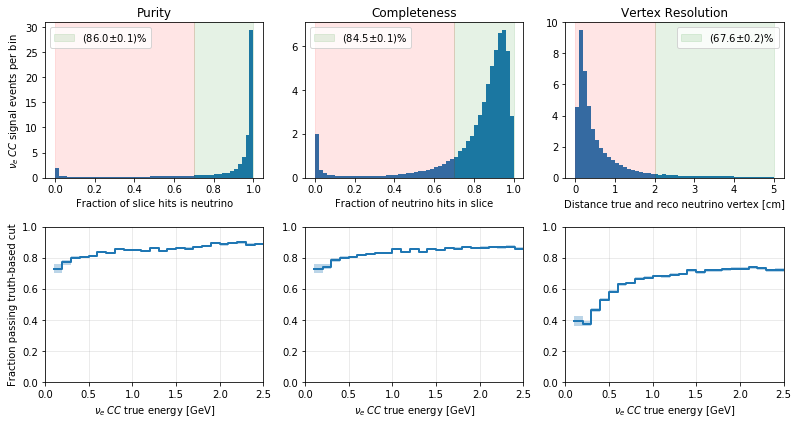

In [13]:
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7*gr,6), sharex=False)
weights = num_nue_sig*[scales[0]]

#energy eff plot:
x_min = 0.1
x_max = 2.5
N = 24
query_arr = ["purity<2",'purity>0.7', 'completeness>0.7', 'mc_nu_vtx_distance<2']
data = [df_mc_nue.query(q)['mc_nu_energy'] for q in query_arr]
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data,where='post')

cut=0.7
ratio = sum(df_mc_nue['purity']>cut)/num_nue_sig
err = helper.effErr(sum(df_mc_nue['purity']>cut),num_nue_sig)
ax[0][0].hist(df_mc_nue['purity'], bins=50, weights=weights, label=None)
ax[0][0].set_title("Purity")
ax[0][0].set_xlabel("Fraction of slice hits is neutrino")
ax[0][0].set_ylabel(sig_str+" signal events per bin")
ax[0][0].axvspan(0,cut, alpha=0.1, color="red")
ax[0][0].axvspan(cut,1, alpha=0.1, color="green", label=r"({0:0.1f}$\pm${1:0.1f})%".format(ratio*100,err*100))
ax[0][0].legend()
ax[1][0].step(edges,bins[1]/bins[0], lw=2, where='post')
err = helper.effErr(bins[1],bins[0])
ax[1][0].fill_between(edges, bins[1]/bins[0] - err, bins[1]/bins[0] + err, alpha=0.3, step='post')
ax[1][0].set_xlabel(sig_str+" true energy [GeV]")
ax[1][0].set_ylim(0,1)
ax[1][0].set_ylabel("Fraction passing truth-based cut")
ax[1][0].grid(alpha=0.3)
ax[1][0].set_xlim(0,x_max)

ratio = sum(df_mc_nue['completeness']>cut)/num_nue_sig
err = helper.effErr(sum(df_mc_nue['completeness']>cut),num_nue_sig)
ax[0][1].hist(df_mc_nue['completeness'], bins=50, weights=weights, label=None)
ax[0][1].set_title("Completeness")
ax[0][1].set_xlabel("Fraction of neutrino hits in slice")
ax[0][1].axvspan(0,cut, alpha=0.1, color="red")
ax[0][1].axvspan(cut,1, alpha=0.1, color="green", label=r"({0:0.1f}$\pm${1:0.1f})%".format(ratio*100,err*100))
ax[0][1].legend()
ax[1][1].step(edges,bins[2]/bins[0], lw=2, where='post')
err = helper.effErr(bins[2],bins[0])
ax[1][1].fill_between(edges, bins[2]/bins[0] - err, bins[2]/bins[0] + err, alpha=0.3, step='post')
ax[1][1].set_xlabel(sig_str+" true energy [GeV]")
ax[1][1].set_ylim(0,1)
ax[1][1].grid(alpha=0.3)
ax[1][1].set_xlim(0,x_max)

cut=2
ratio = sum(df_mc_nue['mc_nu_vtx_distance']<cut)/num_nue_sig
err = helper.effErr(sum(df_mc_nue['mc_nu_vtx_distance']<cut),num_nue_sig)
ax[0][2].hist(df_mc_nue['mc_nu_vtx_distance'], bins=50, range=(0,5), weights=weights, label=None)
ax[0][2].set_title("Vertex Resolution")
ax[0][2].set_xlabel("Distance true and reco neutrino vertex [cm]")
ax[0][2].axvspan(0,cut, alpha=0.1, color="red")
ax[0][2].axvspan(cut,5, alpha=0.1, color="green", label=r"({0:0.1f}$\pm${1:0.1f})%".format(ratio*100,err*100))
ax[0][2].legend()
ax[1][2].step(edges,bins[3]/bins[0], lw=2, where='post')
err = helper.effErr(bins[3],bins[0])
ax[1][2].fill_between(edges, bins[3]/bins[0] - err, bins[3]/bins[0] + err, alpha=0.3, step='post')
ax[1][2].set_xlabel(sig_str+" true energy [GeV]")
ax[1][2].set_ylim(0,1)
ax[1][2].grid(alpha=0.3)
ax[1][2].set_xlim(0,x_max)


#fig.suptitle(title_str)
fig.tight_layout()
#fig.subplots_adjust(top=0.89)
fig.savefig( outdir+"true_nue_quality.pdf")

temp = sum(df_mc_nue.eval('mc_nu_vtx_distance<2 & purity>0.7 & completeness>0.7'))
ratio = temp/num_nue_sig
err = helper.effErr(temp, num_nue_sig)
print('Events passing all truth level quality cuts: ({0:.2f}+-{1:.2f})%'.format(ratio*100,err*100))

### Queries and Dataframes

In [14]:
# Selection Queries
query_hits = "(hitsU+hitsV+hitsY)>100 & hitsU>0 & hitsV>0 & hitsY>0"
query_dedxU = "(abs(start_pitchU)<0.9 & start_hitsU>3 & (start_dedxU<3 & start_dedxU>1)) | (abs(start_pitchU)>0.9 | start_hitsU<4)" 
query_dedxV = "(abs(start_pitchV)<0.9 & start_hitsV>3 & (start_dedxV<3 & start_dedxV>1)) | (abs(start_pitchV)>0.9 | start_hitsV<4)" 
query_dedxY = "(abs(start_pitchY)<0.9 & start_hitsY>3 & (start_dedxY<3 & start_dedxY>1)) | (abs(start_pitchY)>0.9 | start_hitsY<4)" 
query_vtxdist = "vtx_distance < 5"
query_openangle = "0.4 > shower_openangle > 0.04"
query_muonreject = "track_score>0.5 & track_length>30"
query_contained = "~contained"

In [15]:
# Category queries (daughters)
trackscore_max = 0.5

good_str = "mc_neutrino & mc_fidvol &"
cat_e_good = good_str+"abs(mc_pdg)==11 & mc_reco_vtx_distance<5"
cat_p_good = good_str+"abs(mc_pdg)==2212"
cat_g_good = good_str+"mc_pdg==22"
cat_mu_good = good_str+"abs(mc_pdg)==13"
cat_pi_good = good_str+"abs(mc_pdg)==211"
cat_cosmic = "~mc_neutrino"

query_sh = "hitsU>0 & hitsV>0 & hitsY>0 & track_score < @trackscore_max"

In [16]:
df_daughters = [file_dict[sample]["daughters"].pandas.df() for sample in dict_names]

In [17]:
for i in range(4):
    start_mask = helper.inTPC_df(df_daughters[i], 'vx', 'vy', 'vz', fidvol_vtx)
    end_mask = helper.inTPC_df(df_daughters[i], 'track_endx', 'track_endy', 'track_endz', fidvol_end)
    df_daughters[i]['contained'] = start_mask & end_mask 
    df_daughters[i]['hash'] = eventHash(df_daughters[i][['evt_time_sec', 'evt_time_nsec']])
    
    if i<2: #only do this for MC
        df_daughters[i]['mc_fidvol'] = helper.inTPC_df(df_daughters[i], 'mc_vx', 'mc_vy', 'mc_vz', fidvol_vtx)
        # Add distance from true to reco vertex: 
        eval_str = "sqrt( (vx-mc_vx_sce)**2 + (vy-mc_vy_sce)**2 + (vz-mc_vz_sce)**2 )"
        df_daughters[i]['mc_reco_vtx_distance'] = df_daughters[i].eval(eval_str)
        # Add category:
        df_daughters[i]['category'] =  1*df_daughters[i].eval(cat_e_good)+\
                                       2*df_daughters[i].eval(cat_p_good)+\
                                       3*df_daughters[i].eval(cat_g_good)+\
                                       4*df_daughters[i].eval(cat_mu_good)+\
                                       5*df_daughters[i].eval(cat_pi_good)+\
                                       6*df_daughters[i].eval(cat_cosmic)

# Only consider signal events for nue sample
df_daughters[0] = df_daughters[0][df_daughters[0]['evt_time_nsec'].map(timestamp_signal_map)]
df_daughters[0]['mc_nu_energy'] = df_daughters[0]['evt_time_nsec'].map(timestamp_mcenergy_map)

### Data/MC

In [18]:
x_axis_arr  = ["vtx_distance","shower_openangle", "start_dedxY",  "start_dedxU",  "start_dedxV", "caloY"]
x_label_arr = ["Vertex distance [cm]", "Opening Angle [rad]", r"d$E/$d$x$ at start (Y plane) [MeV/cm]", 
               r"d$E/$d$x$ at start (U plane) [MeV/cm]", r"d$E/$d$x$ at start (V plane) [MeV/cm]", "Deposited energy (Y plane)[GeV]"]
query_sh_arr = [query_sh, query_sh, query_sh+" & abs(start_pitchY)<0.9 & start_hitsY>3",
                query_sh+" & abs(start_pitchU)<0.9 & start_hitsU>3",  query_sh+" & abs(start_pitchV)<0.9 & start_hitsV>3", query_sh]
x_min_arr = [0 , 0, 0, 0, 0, 0]
x_max_arr = [10, 0.8, 6.0, 6.0, 6.0, 1]
y_max_arr = [800,1400,800, 800, 800, 5000] 

y_r_min= 0.3
y_r_max= 1.8
N = 40

# Parameters to get the data mc ration in the right spot
ratio_x = 0.20
ratio_y = 8./9
ratio_text = r"$\frac{Beam \ ON}{Beam \ OFF + MC} = $"

In [19]:
cols = x_axis_arr.copy()
cols.append('category')
mc_daughters = pd.concat( [df_daughters[0],df_daughters[1]],  ignore_index=True)

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:3249: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for (thisx, thiserr)


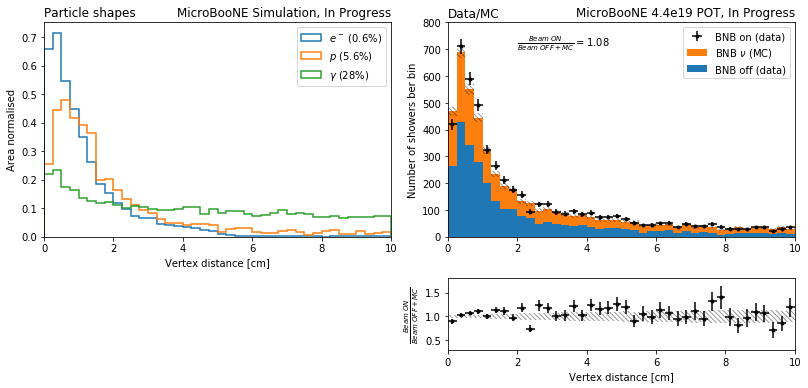

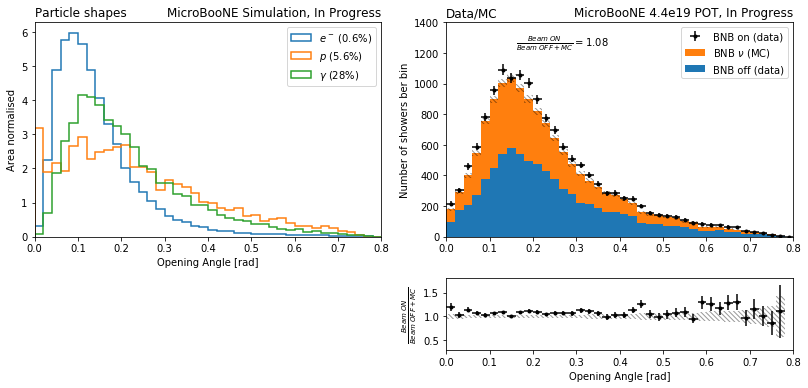

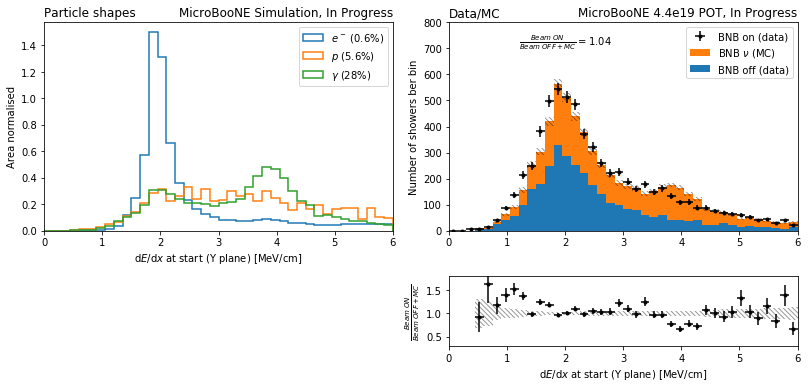

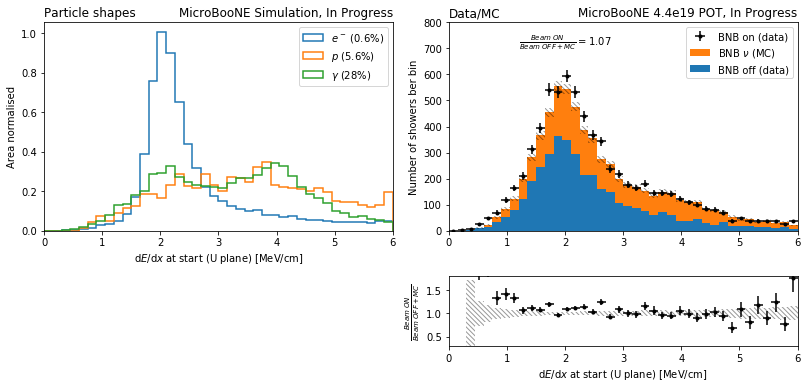

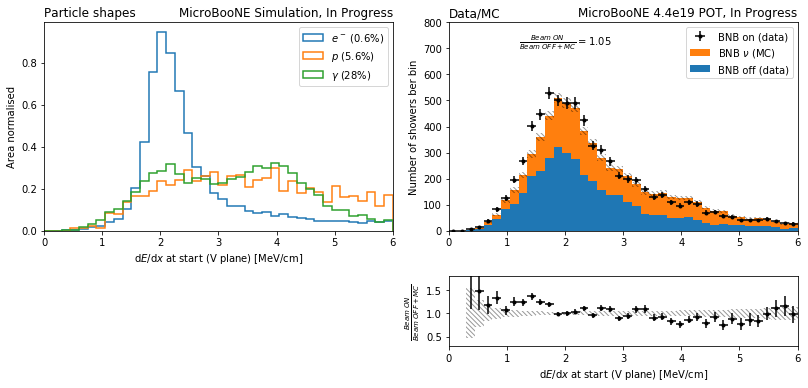

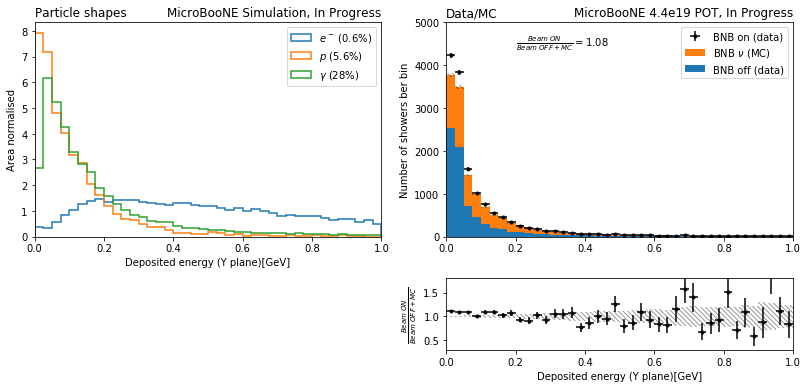

In [20]:
for x_axis, x_label, x_min, x_max, y_max,query  in zip(x_axis_arr, x_label_arr, x_min_arr, x_max_arr, y_max_arr, query_sh_arr):
    fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7*gr,5.5), gridspec_kw = {'height_ratios':[3, 1]})

    # Left plot
    for cat, lab in zip([1,2,3], [r"$e^-$ (0.6%)", r"$p$ (5.6%)", r"$\gamma$ (28%)"]):
        
        data = mc_daughters.query(query).query("category==@cat")[x_axis]
        #print(len(data))
        #print(len(df_daughters[1].query(query).query("category==@cat"))/len(df_daughters[1].query(query)))
        heights,edges,_ = ax[0][0].hist(data,bins=N,alpha=1.0,range=(x_min,x_max),density=True,
                                        label=lab, histtype="step", stacked=False, fill=False, lw=1.5)

    ax[0][0].set_title(r"Particle shapes", loc='left')
    ax[0][0].set_title(r"MicroBooNE Simulation, In Progress", loc='right')
    ax[0][0].legend(loc="upper right")
    ax[0][0].set_xlabel(x_label)
    ax[0][0].set_ylabel("Area normalised")
    ax[0][0].set_xlim(x_min,x_max)
    fig.delaxes(ax[1][0])
    
    # Right plot
    bhalf = (x_max-x_min)/(2*N)
    
    # MC+BNBext
    df_stacked = [df_daughters[3].query(query), df_daughters[1].query(query)]
    lab_stacked = ["BNB off (data)",r"BNB $\nu$ (MC)"]
    lower_total = 0
    err = [0] * N
    
    for df_stack,lab,scale in zip(df_stacked,lab_stacked, [scales[3], scales[1]]):
        df_stack = df_stack[df_stack[x_axis].between(x_min,x_max)][x_axis]
        lower,edges,_ = ax[0][1].hist(df_stack,bins=N,weights=len(df_stack)*[scale], 
                                      range=(x_min,x_max), stacked=False, fill=True,label=lab,bottom=lower_total) 
        err = np.sqrt(np.array(err)**2 + np.array(helper.hist_bin_uncertainty(df_stack.tolist(),len(df_stack)*[scale],edges))**2 ) 
        # This is only allowed in the case of 2 items
        lower_total+=lower

    #Data
    data_bnb = df_daughters[2][df_daughters[2][x_axis].between(x_min,x_max)].query(query)[x_axis]
    values,edges = np.histogram(data_bnb,bins=N,range=(x_min,x_max))
    ax[0][1].errorbar(edges[:-1]+bhalf, values, xerr=bhalf, yerr=np.sqrt(values),alpha=1.0, color= "k",fmt=".",label="BNB on (data)")
    
    ax[0][1].set_title(r"Data/MC", loc='left')
    ax[0][1].set_title(r"MicroBooNE 4.4e19 POT, In Progress", loc='right')
    ax[1][1].set_xlabel(x_label)
    handles, labels = ax[0][1].get_legend_handles_labels()
    ax[0][1].legend(handles[::-1], labels[::-1],loc="upper right")
    ax[0][1].set_ylabel("Number of showers ber bin")
    ax[0][1].set_xlim(x_min,x_max)
    ax[0][1].set_ylim(0,y_max)
    
    ratio = sum(df_daughters[2].eval(query)) / ( scales[1]*len(df_stacked[1]) + scales[3]*len(df_stacked[0]))
    y_max2 = ax[0][1].get_ylim()[1]
    ax[0][1].text(edges[round(N*ratio_x)],ratio_y*y_max2,ratio_text+'{0:.2f}'.format(ratio))

    # Ratio plots
    ax[1][1].set_ylim(y_r_min,y_r_max)
    ax[1][1].set_xlim(x_min,x_max)
    ax[1][1].errorbar(edges[:-1]+bhalf, values/lower_total, xerr=bhalf, yerr=np.sqrt(values)/lower_total ,alpha=1.0, color= "k", fmt=".",label="Data error")

    for this_err,entry,bin_start,bin_end in zip(err,lower_total,edges[:-1],edges[1:]):
        ax[0][1].add_patch(patches.Rectangle( (bin_start, entry-this_err), bin_end-bin_start, this_err*2, hatch="\\\\\\\\\\",Fill=False, linewidth=0,alpha=0.4))
        sc_err = this_err/entry
        ax[1][1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), bin_end-bin_start, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')

    fig.tight_layout()
    fig.savefig((outdir+x_axis+".pdf"))

### Selection

In [21]:
# At least one daughter should have:
query_select_arr = ["hitsSps>0", query_hits, query_dedxY, query_dedxV, query_dedxU, query_vtxdist, query_openangle] 
# None of the daughters should have:
query_reject_arr = [query_contained, query_muonreject]

num_nue_sig_start = num_nue_sig_all
num_off_start = file_dict["off"]["all_events"].numentries

In [22]:
df_view = df_daughters
signal_pass_mc_energy = []

for query in query_select_arr:
    #print(query)
    df_view = [df.query(query) for df in df_view]
    num_pass = [len(df.drop_duplicates(['hash'])) for df in df_view]
    signal_pass_mc_energy.append(df_view[0].drop_duplicates(['hash'])['mc_nu_energy'])
    EffPurPrinter(num_pass)

for query in query_reject_arr:
    #print(query)
    reject = [np.unique(df['hash'][df.eval(query)]) for df in df_daughters]
    df_view = [df[~df['hash'].isin(r)] for df,r in zip(df_view, reject)]
    num_pass = [len(df.drop_duplicates(['hash'])) for df in df_view]
    EffPurPrinter(num_pass)
    signal_pass_mc_energy.append(df_view[0].drop_duplicates(['hash'])['mc_nu_energy'])

Eff: (87.12+-0.12)%	Purity_MC: (0.32+-0.04)%	Purity: (0.13+-0.02)%	Data/MC: 1.10	 Off passing fraq: (21.42+-0.11)%
Eff: (85.61+-0.13)%	Purity_MC: (0.33+-0.04)%	Purity: (0.14+-0.02)%	Data/MC: 1.10	 Off passing fraq: (20.22+-0.11)%
Eff: (74.08+-0.16)%	Purity_MC: (0.32+-0.04)%	Purity: (0.13+-0.02)%	Data/MC: 1.10	 Off passing fraq: (18.93+-0.11)%
Eff: (67.55+-0.17)%	Purity_MC: (0.32+-0.05)%	Purity: (0.13+-0.02)%	Data/MC: 1.10	 Off passing fraq: (16.73+-0.10)%
Eff: (62.04+-0.18)%	Purity_MC: (0.31+-0.05)%	Purity: (0.13+-0.02)%	Data/MC: 1.10	 Off passing fraq: (15.77+-0.10)%
Eff: (48.81+-0.18)%	Purity_MC: (0.27+-0.05)%	Purity: (0.11+-0.02)%	Data/MC: 1.10	 Off passing fraq: (14.13+-0.10)%
Eff: (33.07+-0.17)%	Purity_MC: (0.74+-0.15)%	Purity: (0.35+-0.07)%	Data/MC: 1.15	 Off passing fraq: (2.64+-0.04)%
Eff: (23.71+-0.15)%	Purity_MC: (1.09+-0.26)%	Purity: (0.71+-0.17)%	Data/MC: 0.94	 Off passing fraq: (0.62+-0.02)%
Eff: (15.54+-0.13)%	Purity_MC: (4.92+-1.44)%	Purity: (2.62+-0.78)%	Data/MC: 0.98	 

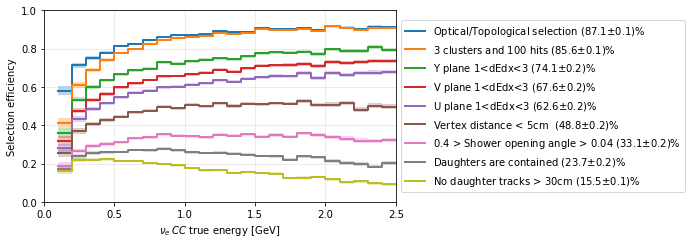

In [23]:
#Plot Eff for nue signal:
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(6*gr,3.5), sharex=False)
weights = num_nue_sig*[scales[0]]

labels = [r"Optical/Topological selection (87.1$\pm$0.1)%", 
          r"3 clusters and 100 hits (85.6$\pm$0.1)%", 
          r"Y plane 1<dEdx<3 (74.1$\pm$0.2)%",
          r"V plane 1<dEdx<3 (67.6$\pm$0.2)%",
          r"U plane 1<dEdx<3 (62.6$\pm$0.2)%",
          r"Vertex distance < 5cm  (48.8$\pm$0.2)%",
          r"0.4 > Shower opening angle > 0.04 (33.1$\pm$0.2)%",
          r"Daughters are contained (23.7$\pm$0.2)%",
          r"No daughter tracks > 30cm (15.5$\pm$0.1)%"
         ]

#energy eff plot:
x_min = 0.1
x_max = 2.5
N = 24
data = signal_pass_mc_energy
data.append(nue_energy_all)
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data,where='post')
    
for cut,lab in zip(bins[:-1], labels):
    err = helper.effErr(cut,bins[-1])
    ax.step(edges,cut/bins[-1], lw=2, where='post', label=lab)
    ax.fill_between(edges, cut/bins[-1] - err, cut/bins[-1] + err, alpha=0.3, step='post')
    
ax.set_xlabel(sig_str+" true energy [GeV]")
ax.set_ylim(0,1)
ax.grid(alpha=0.3)
ax.set_xlim(0,x_max)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("Selection efficiency")
fig.tight_layout()
fig.savefig( outdir+"true_nue_energy_selection.pdf")